In [ ]:
import matplotlib.pyplot    as plt
import torch
import torch.nn             as nn
import torch.nn.functional  as F
from torchvision.datasets   import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data       import DataLoader
from torchvision.utils      import make_grid
from tqdm                   import tqdm

In [ ]:
transform = Compose([Resize((32, 32)), ToTensor(),])


train_dataset = FashionMNIST(
    root      = "~/fashionMNIST_dataset",
    train     = True,
    transform = transform,
    download  = True
)

test_dataset = FashionMNIST(
    root      = "~/fashionMNIST_dataset",
    train     = False,
    transform = transform,
    download  = True
)

tr_batch_size  = 128
ts_batch_size  = 64
trainloader    = DataLoader(train_dataset, batch_size=tr_batch_size, shuffle=True )
testloader     = DataLoader(test_dataset,  batch_size=ts_batch_size, shuffle=False)

100%|██████████| 26421880/26421880 [00:02<00:00, 11854999.10it/s]


Extracting /root/fashionMNIST_dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/fashionMNIST_dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 204375.07it/s]


Extracting /root/fashionMNIST_dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/fashionMNIST_dataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3838538.22it/s]


Extracting /root/fashionMNIST_dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/fashionMNIST_dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7190235.43it/s]


Extracting /root/fashionMNIST_dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/fashionMNIST_dataset/FashionMNIST/raw



In [ ]:
print("Classi nel dataset: ", train_dataset.classes)
print("Train set shape:    ", train_dataset.data.shape)
print("Test set shape:     ", test_dataset.data.shape)

Classi nel dataset:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Train set shape:     torch.Size([60000, 28, 28])
Test set shape:      torch.Size([10000, 28, 28])


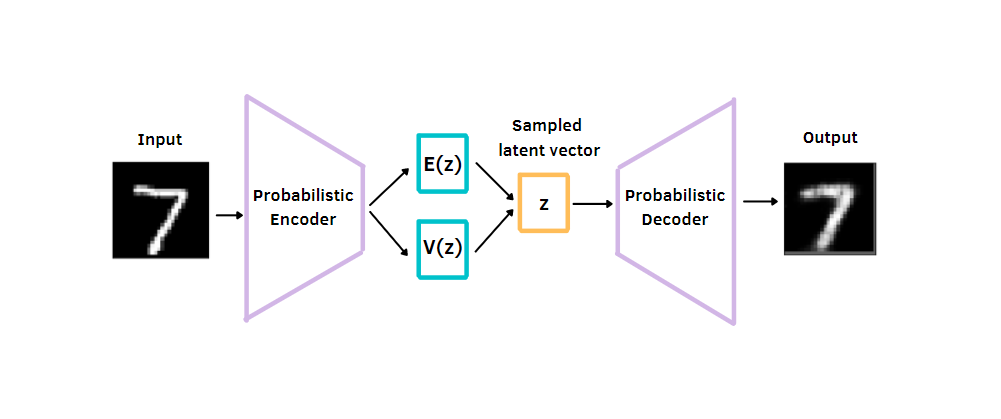

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, image_channels, init_channels, kernel_size, latent_dim):
        super(ConvVAE, self).__init__()

        # ENCODER
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels,
            kernel_size=kernel_size, stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2,
            kernel_size=kernel_size, stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4,
            kernel_size=kernel_size, stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64,
            kernel_size=kernel_size, stride=2, padding=0
        )

        # FULLY CONNECTED LAYERS
        self.fc1        = nn.Linear(64, 128)
        self.fc_mu      = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2        = nn.Linear(latent_dim, 64)

        # DECODER
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size,
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4,
            kernel_size=kernel_size, stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2,
            kernel_size=kernel_size, stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels,
            kernel_size=kernel_size, stride=2, padding=1
        )

    # Prende in ingresso la media mu e log variance. Entrambe sono costruite attraverso
    # lo spazio latende codificato dall'autoencoder
    def reparameterize(self, mu, log_var):
        # Ritorna un tensore contentente l'esponenziale di ogni elemento del tensore di input.
        std = torch.exp(0.5*log_var) # standard deviation
        # Ritorna un tensore avente stessa lunghezza del tensore di input il quale
        # è riempito con numeri random secondo una distribuzione normale con media
        # 0 e varianza 1.
        eps = torch.randn_like(std)  # randn_like as we need the same size
        sample = mu + (eps * std)    # sampling
        return sample

    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))

        batch, _, _, _ = x.shape
        # In Adaptive Pooling viene specificata solo la dimensione dell'uscita.
        # Lo  'stride' e il 'kernel-size' vengono calcolate dall'algoritmo.
        # reshape(batch, -1) collassa ogni immagine in un vettore
        x      = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)

        # get 'mu' and 'log_var'
        mu      = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)

        # Otteniamo il latent vector attraverso la riparametrizzazione.
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1)

        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))

        return reconstruction, mu, log_var



kernel_size    = 4 # (4, 4) kernel
init_channels  = 8 # initial number of filters
image_channels = 1 # MNIST images are grayscale
latent_dim     = 16 # latent dimension for sampling
model          = ConvVAE(image_channels, init_channels, kernel_size, latent_dim)
model

ConvVAE(
  (enc1): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=16, bias=True)
  (fc_log_var): Linear(in_features=128, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=64, bias=True)
  (dec1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
  (dec2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec4): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [ ]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    losses = []
    for batch, _ in tqdm(dataloader):
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(batch)
        bce_loss = criterion(reconstruction, batch)
        loss     = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) + bce_loss
        loss.backward()
        losses.append(loss)
        optimizer.step()

    return torch.stack(losses).mean().item()


def validate(model, dataloader, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for batch, _ in tqdm(dataloader):
            reconstruction, mu, logvar = model(batch)
            bce_loss = criterion(reconstruction, batch)
            loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) + bce_loss
            losses.append(loss)

    val_loss = torch.stack(losses).mean().item()
    # Ritorniamo l'ultimo batch per ongi epoca. Ci servirà per comprendere la ricostruzione (ultimo batch come esempio)
    return val_loss, reconstruction, batch

In [ ]:
def to_device(data, device):
    """Sposta i tensori sul device selezionato"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Dataloader per caricare i dati sul device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Sposta il batch sul device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Numero di batch"""
        return len(self.dl)


device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dl = DeviceDataLoader(trainloader, device)
val_dl   = DeviceDataLoader(testloader, device)
model    = to_device(model, device);

In [ ]:
lr             = 0.001
epochs         = 10
nrow           = 8
optimizer      = torch.optim.Adam(model.parameters(), lr=lr)
criterion      = nn.BCELoss(reduction='sum')

train_loss     = []
valid_loss     = []
grid_images_or = []
grid_images_rc = []


for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss                   = train(model, train_dl, optimizer, criterion)
    valid_loss_ep, recostr, last_batch = validate(model, val_dl, criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_loss_ep)
    image_grid_rc = make_grid(recostr.detach().cpu(), nrow=nrow)
    image_grid_or = make_grid(last_batch.detach().cpu(), nrow=nrow)
    grid_images_rc.append(image_grid_rc)
    grid_images_or.append(image_grid_or)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_loss_ep:.4f}")


#https://debuggercafe.com/convolutional-variational-autoencoder-in-pytorch-on-mnist-dataset/

Epoch 1 of 10


100%|██████████| 157/157 [00:02<00:00, 76.13it/s]


Train Loss: 53333.9375
Val Loss: 22266.4668
Epoch 2 of 10


100%|██████████| 157/157 [00:01<00:00, 89.76it/s]


Train Loss: 43489.9609
Val Loss: 21604.0371
Epoch 3 of 10


100%|██████████| 157/157 [00:01<00:00, 89.60it/s]


Train Loss: 42832.4375
Val Loss: 21368.9395
Epoch 4 of 10


100%|██████████| 157/157 [00:01<00:00, 89.99it/s]


Train Loss: 42599.9297
Val Loss: 21299.9902
Epoch 5 of 10


100%|██████████| 157/157 [00:02<00:00, 70.15it/s]


Train Loss: 42468.6016
Val Loss: 21237.9180
Epoch 6 of 10


100%|██████████| 157/157 [00:03<00:00, 48.63it/s]


Train Loss: 42367.6953
Val Loss: 21196.4570
Epoch 7 of 10


100%|██████████| 157/157 [00:01<00:00, 89.66it/s]


Train Loss: 42291.6367
Val Loss: 21219.8223
Epoch 8 of 10


100%|██████████| 157/157 [00:01<00:00, 92.37it/s]


Train Loss: 42231.4141
Val Loss: 21143.2676
Epoch 9 of 10


100%|██████████| 157/157 [00:01<00:00, 90.46it/s]


Train Loss: 42191.1133
Val Loss: 21166.1875
Epoch 10 of 10


100%|██████████| 157/157 [00:01<00:00, 86.68it/s]

Train Loss: 42152.7812
Val Loss: 21135.2285


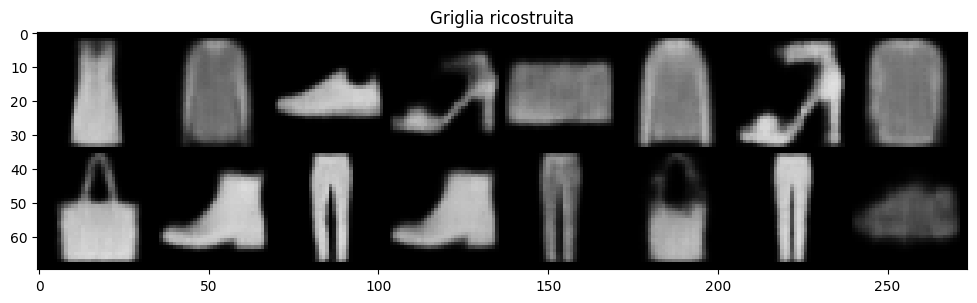

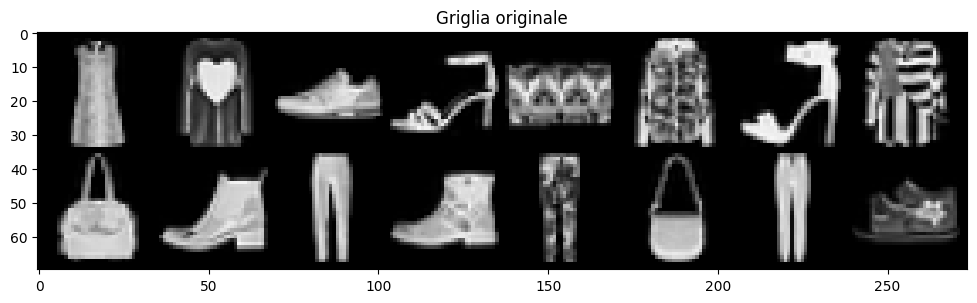

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(make_grid(grid_images_rc[-1], nrow=8).permute(1, 2, 0))
ax.set_title("Griglia ricostruita")
plt.show()

print("\n")

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(make_grid(grid_images_or[-1], nrow=8).permute(1, 2, 0))
ax.set_title("Griglia originale")
plt.show()